In [ ]:
#!pip install torch
#!pip install optuna

In [9]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from optuna.samplers import RandomSampler
import optuna

# Определение нейронной сети для аппроксимации Q-функции
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=24, bias=True):
        super(QNetwork, self).__init__()
        # Простая сеть с одним скрытым слоем
        self.fc1 = nn.Linear(state_size, hidden_size, bias)
        self.fc2 = nn.Linear(hidden_size, action_size, bias)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Среда (упрощенная для примера)
class SimpleEnv:
    def __init__(self):
        self.state_space_size = 4
        self.action_space_size = 2

    def step(self, state, action):
        next_state = (state + 1) % self.state_space_size
        reward = 1 if action == 0 else -1
        done = next_state == 0
        return next_state, reward, done

    def reset(self):
        return 0

def train(env, model, episodes=1000, learning_rate=0.01, gamma=0.95):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()
    total_reward = 0

    for episode in range(episodes):
        state = env.reset()
        done = False
        episode_reward = 0

        while not done:
            state_tensor = torch.FloatTensor([state])
            q_values = model(state_tensor)

            # Исправление: Изменение выбора действия
            _, action = torch.max(q_values, dim=0)
            action = action.item()

            next_state, reward, done = env.step(state, action)
            episode_reward += reward

            next_state_tensor = torch.FloatTensor([next_state])
            next_q_values = model(next_state_tensor)

            target_q = reward + gamma * torch.max(next_q_values)
            loss = loss_fn(q_values[action], target_q)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state

        total_reward += episode_reward

    return total_reward / episodes

def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1)
    gamma = trial.suggest_float('gamma', 0.50, 0.99)
    hidden_size = trial.suggest_int('hidden_size', 2, 128)
    bias = trial.suggest_categorical('bias', [True, False])
    episodes = 100

    model = QNetwork(1, 2, hidden_size, bias)
    env = SimpleEnv()
    average_reward = train(env, model, episodes, learning_rate, gamma)

    return average_reward

study = optuna.create_study(direction='maximize',storage="sqlite:///db.sqlite3", study_name="quadratic-simple4", sampler=RandomSampler())
study.optimize(objective, n_trials=100)

print("Best parameters:", study.best_params)

[I 2024-03-17 13:28:46,329] A new study created in RDB with name: quadratic-simple4


[I 2024-03-17 13:28:46,853] Trial 0 finished with value: 4.0 and parameters: {'learning_rate': 0.0486666836689059, 'gamma': 0.5749854901645786, 'hidden_size': 125, 'bias': False}. Best is trial 0 with value: 4.0.
[I 2024-03-17 13:28:47,291] Trial 1 finished with value: 4.0 and parameters: {'learning_rate': 0.06718788444916267, 'gamma': 0.6633378302981519, 'hidden_size': 43, 'bias': False}. Best is trial 0 with value: 4.0.
[I 2024-03-17 13:28:47,801] Trial 2 finished with value: 4.0 and parameters: {'learning_rate': 0.03974661114255837, 'gamma': 0.8032764748044541, 'hidden_size': 121, 'bias': True}. Best is trial 0 with value: 4.0.
[I 2024-03-17 13:28:48,238] Trial 3 finished with value: -2.0 and parameters: {'learning_rate': 0.03851373263608431, 'gamma': 0.5716980488168055, 'hidden_size': 77, 'bias': False}. Best is trial 0 with value: 4.0.
[I 2024-03-17 13:28:48,666] Trial 4 finished with value: 4.0 and parameters: {'learning_rate': 0.03068141862807773, 'gamma': 0.714467394451844, 'hi

Best parameters: {'learning_rate': 0.0486666836689059, 'gamma': 0.5749854901645786, 'hidden_size': 125, 'bias': False}


In [6]:
#!pip install optuna-dashboard
#!optuna-dashboard sqlite:///db.sqlite3

^C


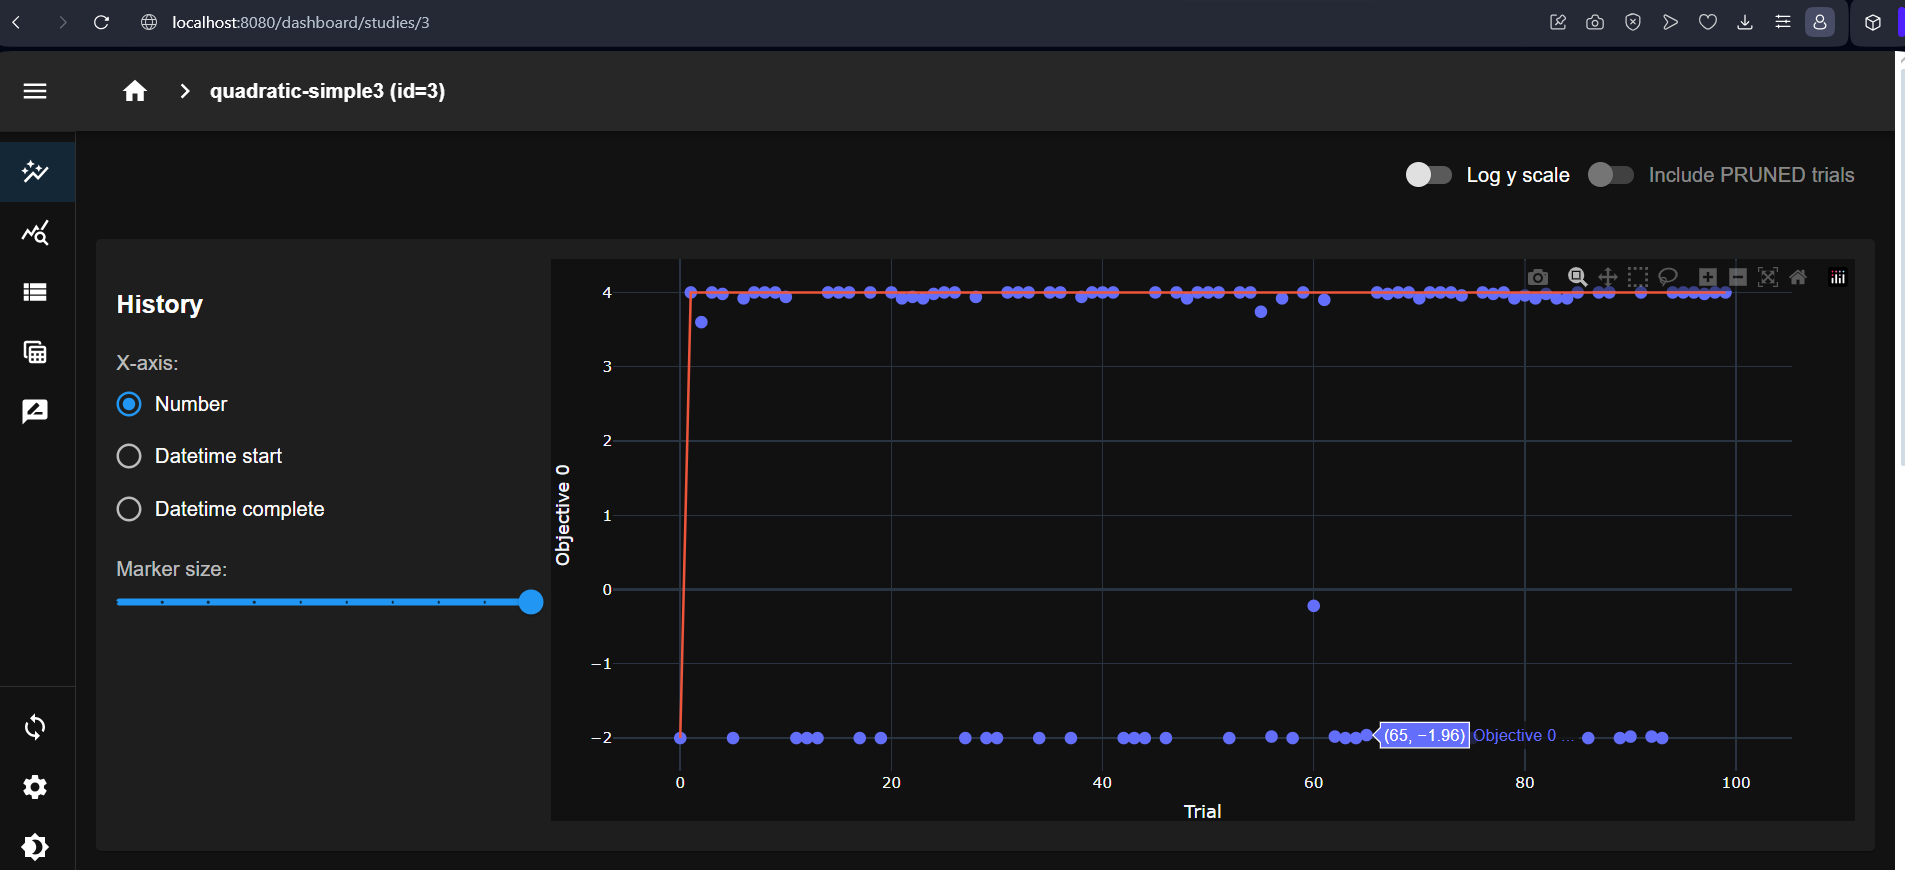

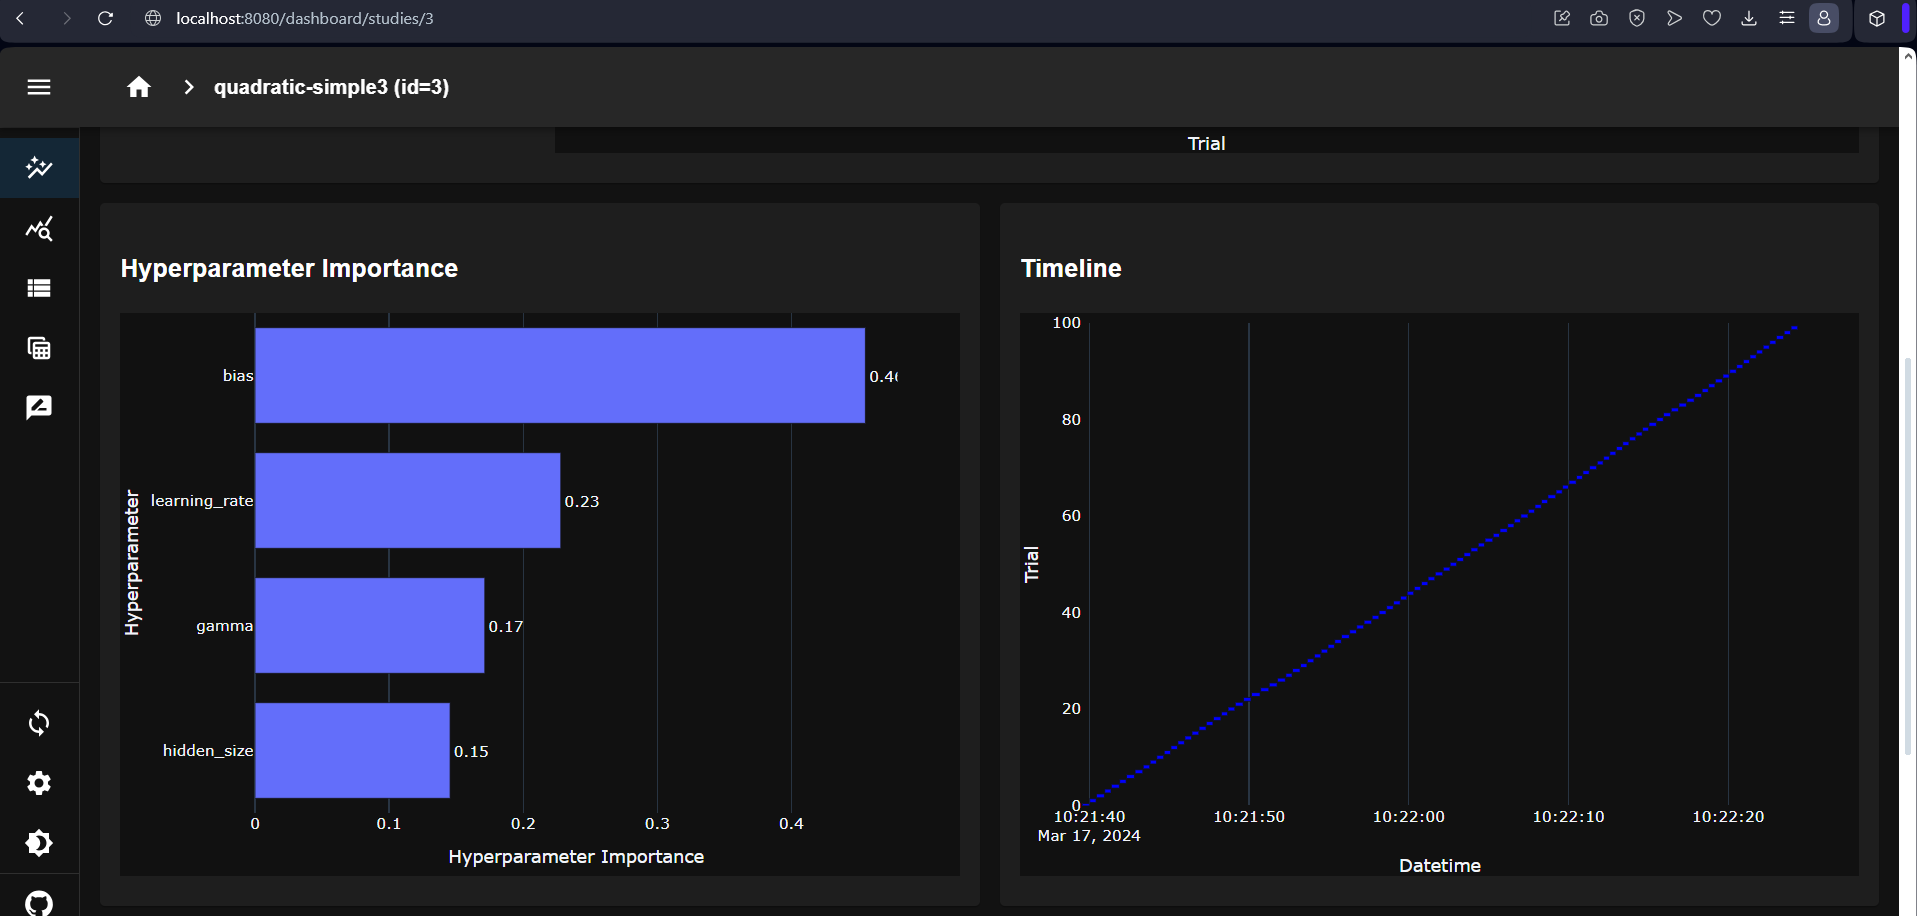

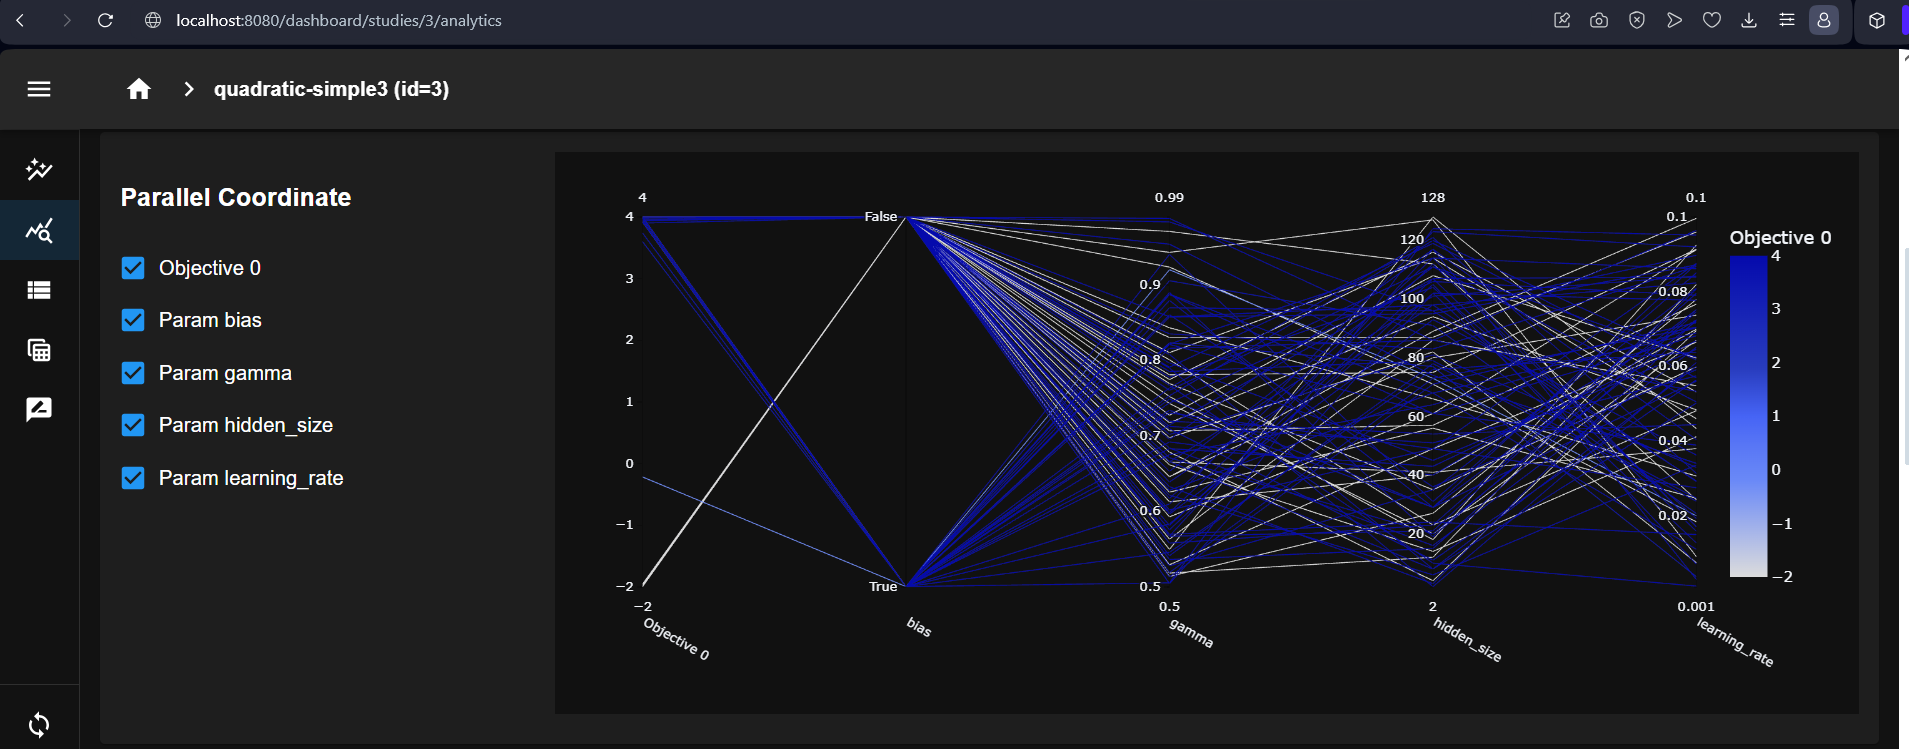

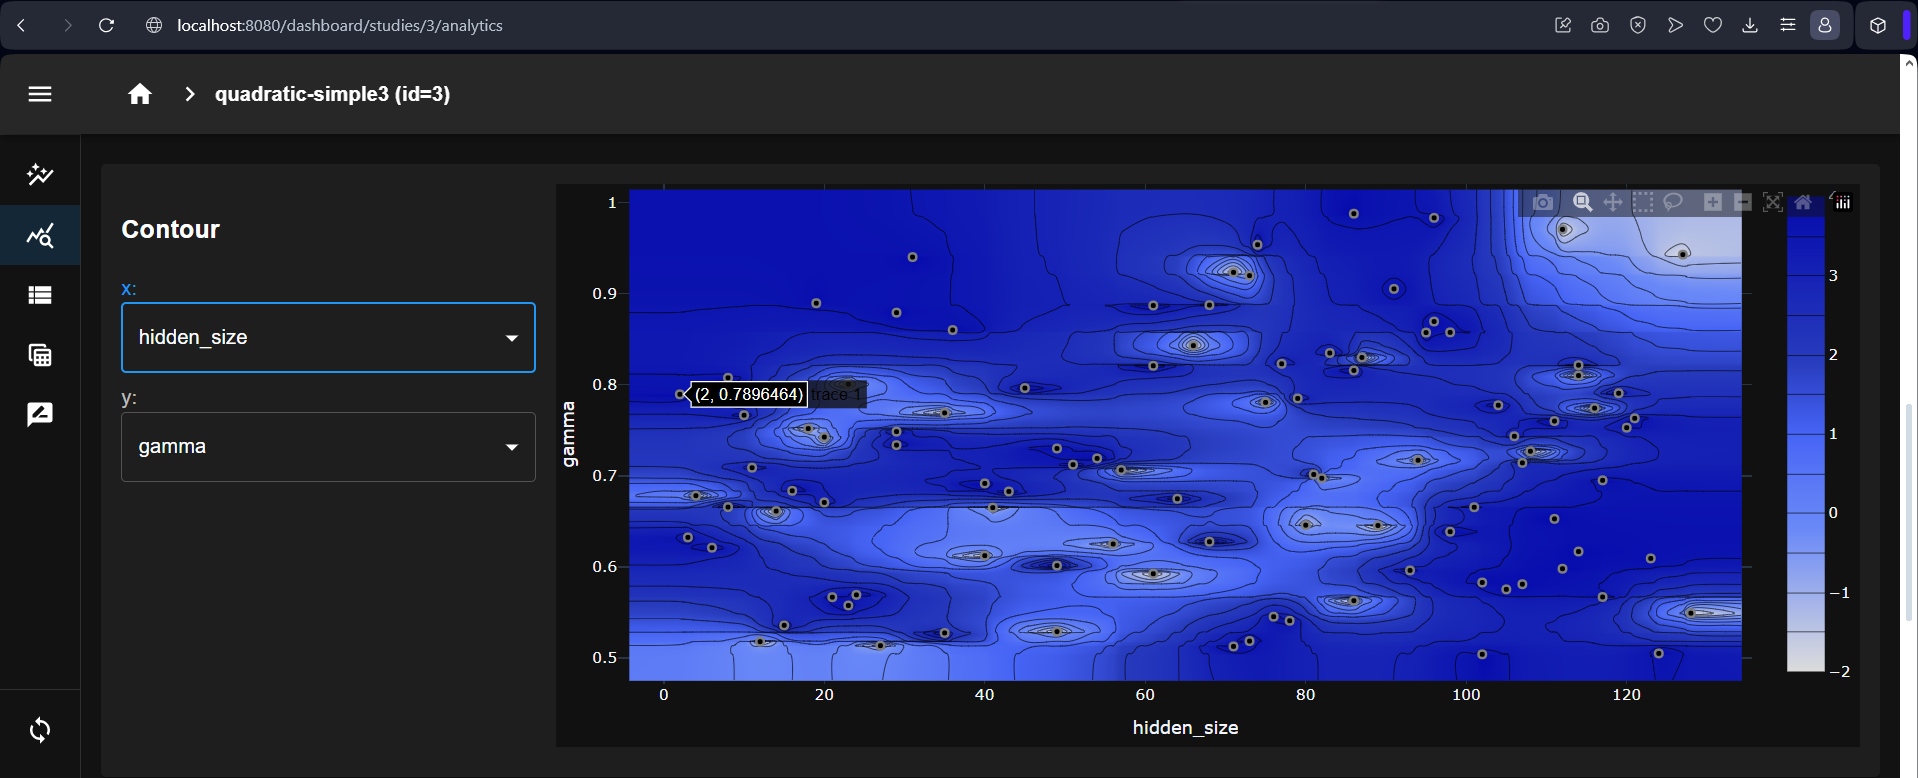

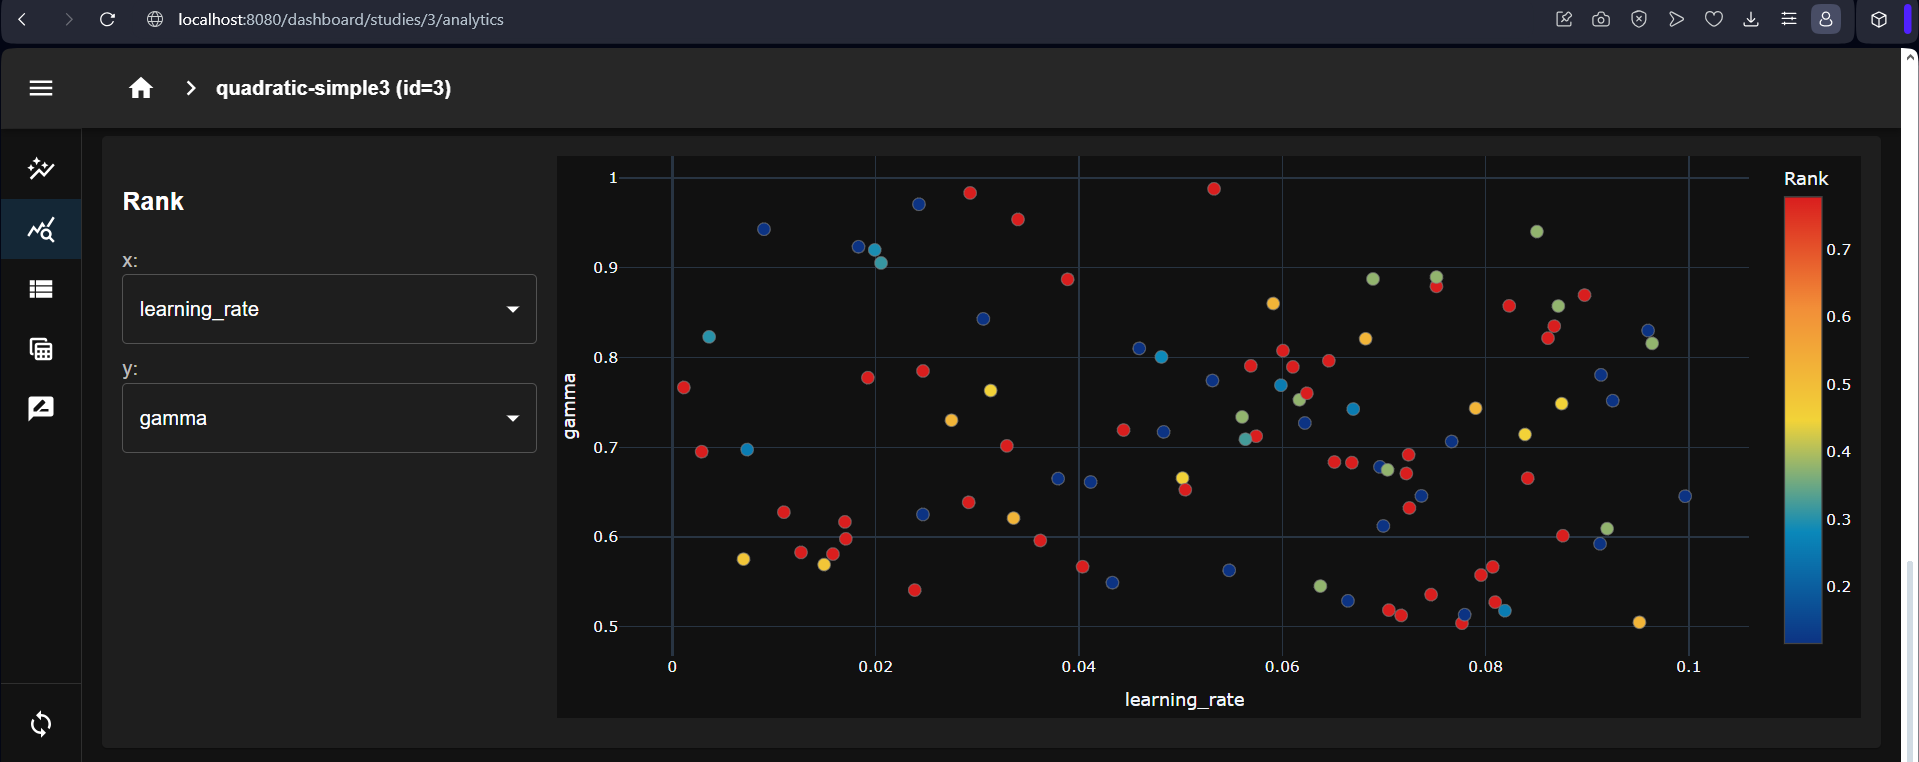